# Shape Space

> **_Tip:_** Launch live version of this tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/morphomatics/morphomatics.github.io/HEAD?filepath=docs%2Ftutorials%2Ftutorial_shape_space.ipynb)

A key component in the analysis of shape collections is the notion of a shape space, i.e. a space in which every point corresponds to a particular shape.
We will follow a deformation-based approach where a common deformable template encodes the typicality of the object class under study.
The shape variability in turn is encoded by deformations of the template (referred to as reference shape in the following).

## Discrete representation

To obtain a computational model, we require a digital representation of shapes and variations thereof.
To this end, we employ triangular surface meshes for which we provide the `Surface` class.
A surface mesh is specified by a pair of matrices:

$v = \begin{bmatrix} x_0 & y_0 & z_0 \\ x_1 & y_1 & z_1 \\ & \vdots & \end{bmatrix} \in \mathbb{R}^{n \times 3}
\text{ and }
f = \begin{bmatrix} i_0 & j_0 & k_0 \\ i_1 & j_1 & k_1 \\ & \vdots & \end{bmatrix} \in \mathbb{R}^{m \times 3},$

where $v$ holds the coordinates of $n$ vertices and $f$ lists which vertices (i.e. indices thereof w.r.t. $v$) form each of $m$ triangles.
For example, we can create a tetrahedron like this:

In [ ]:
import numpy as np
from morphomatics.geom import Surface

# 4 vertices
v = np.array([
    [0.57735, 0.57735, 0.57735],
    [-0.57735, 0.57735, -0.57735],
    [-0.57735, -0.57735, 0.57735],
    [0.57735, -0.57735, -0.57735]
])

# 4 triangles
# note: by sharing vertices (each is referenced 3 times), triangles are 'glued' together
f = np.array([
    [0, 3, 1],
    [1, 3, 2],
    [1, 2, 0],
    [0, 2, 3]
])

S = Surface(v, f)

# compute area of surface
S.face_areas.sum()

In order to encode deformations, hence shape variations, we focus on simplicial maps, i.e. deformations that map triangles onto triangles and are entirely determined by the images of the vertices.
Given a triangulated reference shape $(\bar{v}, \bar{f})$, each surface in a collection can be represented by a mesh with same connectivity $f_i \equiv \bar{f}$ and mapped vertices $v_i = \phi_i(\bar{v})$.
The task of determining the $\phi_i$ is known as correspondence problem.
There is a multitude of approaches to establish correspondence ranging from fully automatic to expert guided ones.
The best choice is typically application dependent and we assume that this step has been carried out during pre-process.


## Geometric structure

Codifying shapes as simplicial deformations allows to interpret them as elements in the space of vertex coordinates $\mathbb{R}^{n \times 3}$.
This configuration space not only encodes the geometric form of objects but also their scale, position and orientation within the 3D space they are embedded in.

We can endow this space with a rich geometric structure by equipping it with a non-trivial metric that quantifies shape (dis)similarity.
Ideally, for shape spaces we require the metric to be invariant under rotations and translations.
We can further adopt a physically-based perspective and design the metric to favor natural deformations promising an improved consistency and compact encoding of constraints.

The different approaches available within morphomatics are sub-classes of `ShapeSpace` (in `morphomatics.manifold.ShapeSpae`).
The available shape spaces are:

* __Kendall's shape space__ (see `morphomatics.manifold.Kendall`)
    An established model due to D. G. Kendall that represent the shape of a 3D object by a finite number of points called landmarks (i.e. the vertices `v` of a surface in our implementation).
    The shape space is endowed with a metric that is invariant under rotation, translation, and scaling and is based on the Procrustes distance between shapes.
    
* __Point distribution model__ (see `morphomatics.manifold.PointDistributionModel`)
    A linearized, i.e. Euclidean, model approximating Kendall's shape space commonly used in geometric morphometrics as it allows for multivariate statistics.
    Rotational and translational effects are reduced via Procrustes alignment to the reference shape.

* __Differential coordinates model__ (see `morphomatics.manifold.DifferentialCoords`)
    A Riemannian shape space that is able to account for the nonlinearity in shape variation by employing a differential representation that puts the local geometric variability into focus.
    The differential coordinates are endowed with a Lie group structure that comes with both:
    Excellent theoretical properties and closed-form expressions yielding simple and efficient algorithms.
    While translation invariant, rotational effects are reduced via Procrustes alignment to the reference shape.
    
* __$GL^+(3)$ coordinates model__ (see `morphomatics.manifold.GLpCoords`)
    Similar to the differential coordinates model, but putting the affine group structure of deformation gradients into focus.
    Note: The `jax` library does not provide a stable implementation of the matrix logarithm, thus, limiting the applicability of this model.

* __Fundamental coordinates model__ (see `morphomatics.manifold.FundamentalCoords`)
   A surface-theoretic approach that is invariant under Euclidean motion and thus alignment-free.
   The rich structure of the derived shape space assures valid shape instances even in presence of strong nonlinear variability.
   The representation builds upon metric distortion and curvature of shapes as elements of Lie groups that allow for closed-form evaluation of Riemannian operations.

Besides a metric, the spaces can be equipped with a connection that provides a notion of parallelism and straightest paths.
Given a starting point and a direction, a connection allows walking along shape space - a function known as exponential map.

Shape spaces (and more generally manifolds) may be set up with different metrics and connections realized as sub-classes of `Metric` and `Connection` in `morphomatics.manifold`, respectively.

## Geodesic calculus

Due to the inherent non-linearity, calculus in non-Euclidean shape spaces can be computationally challenging.
Remarkably, the shape spaces provided here offer fast and numerically robust processing.
For example, computing geodesic distances or exponential/logarithmic maps does not require iterative approximation schemes.

distance:  1.1917492


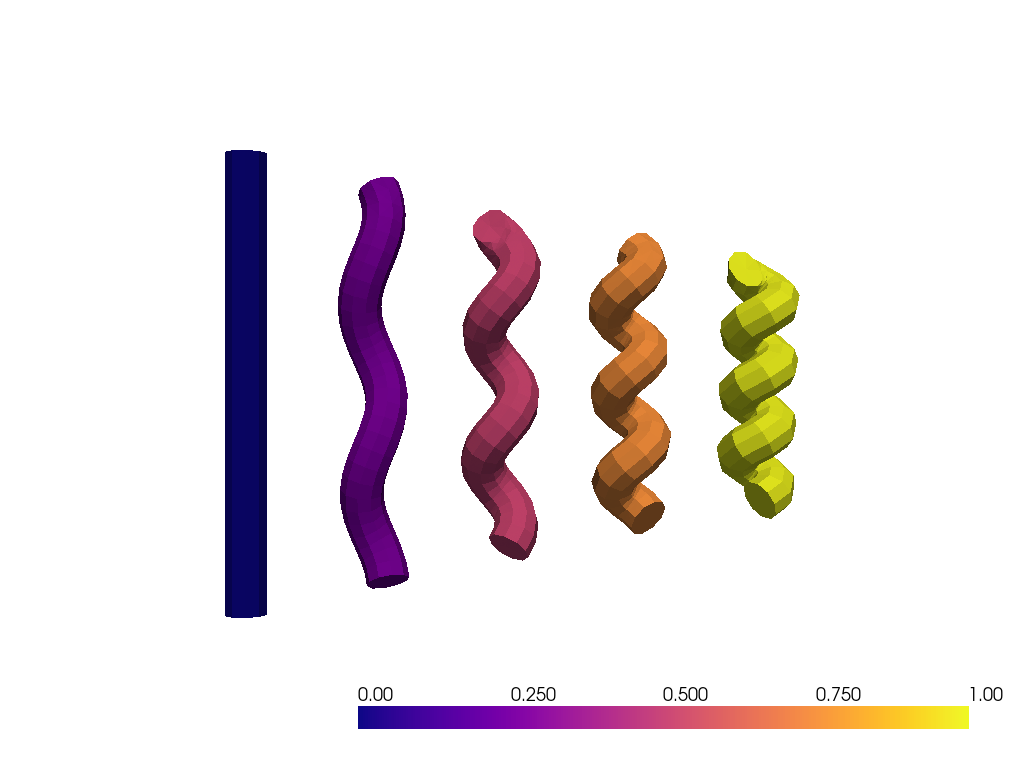

In [8]:
import pyvista as pv
from morphomatics.manifold import FundamentalCoords, util

# Read example data

mesh_straight = pv.read('../data/straight.obj')
mesh_helix = pv.read('../data/helix.obj')

as_surface = lambda mesh: Surface(mesh.points, mesh.faces.reshape(-1, 4)[:, 1:])
S_straight = as_surface(mesh_straight)
S_helix = as_surface(mesh_helix)

# Construct shape space
M = FundamentalCoords(S_straight)

# map surfaces to shape space coordinates
c_straight = M.to_coords(S_straight.v)
c_helix = M.to_coords(S_helix.v)

# perform computations, e.g. ...

# ... compute distance
print('distance: ', M.metric.dist(c_straight, c_helix))

# ... interpolate surfaces (mid-point on geodesic)
diff = M.connec.log(c_straight, c_helix)
mean = M.connec.exp(c_straight, 0.5*diff)

# get vertex coordinates of mean
v = M.from_coords(mean)

# visualize
pl = pv.Plotter(notebook=True)
import matplotlib.pyplot as plt
cmap = plt.colormaps['plasma']
for t in np.linspace(0,1,5):
     # compute interpolating shape
     v = M.from_coords(M.connec.exp(c_straight, t*diff))
     # align and move upwards
     v = util.align(v, S_straight.v) + t*np.array([0.,0.,10.])
     # add to plot
     pl.add_mesh(pv.PolyData(np.asarray(v), mesh_straight.faces),
                 scalars=np.full_like(v[:,0], t), cmap=cmap)
pl.view_zx()
pl.show(jupyter_backend='static')



In [ ]:
""" Client-side rendering with `ipygany` and `ipywidgets` for interaction. """

from ipywidgets import interact
from ipygany import PolyMesh, Scene

# create viewer
mesh = pv.PolyData(np.asarray(v), np.c_[np.full(len(S_straight.f), 3), S_straight.f])
scn = Scene([PolyMesh.from_vtk(mesh)])

@interact
def plot(t=(0,1,.01)):
    # interpolate: walk along connecting geodesic
    v = M.from_coords(M.connec.exp(c_straight, t*diff))
    scn.children[0].vertices = v

scn